# GSM Lagrange with AiiDA Storage Demonstration

This notebook demonstrates how to run a GSM Lagrange material simulation and store the results in AiiDA for persistent storage and provenance tracking.

We'll use the elastic-damage model (`GSM1D_ED`) and show how to:
1. Run a material simulation using the GSM framework
2. Store results in AiiDA using the ResponseDataNode
3. Retrieve and visualize stored results
4. Query simulation metadata

This represents a modern workflow for computational materials science with full data management.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import traits.api as tr
import bmcs_utils.api as bu

# Import the GSM framework
from bmcs_matmod.gsm_lagrange.core.gsm_model import GSMModel
from bmcs_matmod.gsm_lagrange.models.gsm1d_ed import GSM1D_ED

# For nicer plot display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
try:
    plt.style.use('bmcs')
except:
    pass

print("✓ GSM Lagrange framework imported successfully")

✓ GSM Lagrange framework imported successfully


## 1. Check AiiDA Availability and Profile Status

Before we can store results in AiiDA, let's check if it's available and properly configured:

In [2]:
def check_aiida_status():
    """Check AiiDA availability and profile status"""
    try:
        import aiida
        from aiida.manage import get_manager
        print("✓ AiiDA is installed")
        
        try:
            manager = get_manager()
            profile = manager.get_profile()
            print(f"✓ AiiDA profile loaded: {profile.name}")
            return True, "ready"
        except Exception as e:
            print(f"⚠ No AiiDA profile loaded: {e}")
            
            # Try to load a profile automatically
            try:
                aiida.load_profile()
                manager = get_manager()
                profile = manager.get_profile()
                print(f"✓ AiiDA profile auto-loaded: {profile.name}")
                return True, "auto-loaded"
            except Exception as load_error:
                print(f"❌ Failed to load AiiDA profile: {load_error}")
                print("   Simulation will run without AiiDA storage")
                return False, "no-profile"
                
    except ImportError:
        print("❌ AiiDA not installed")
        print("   Install with: pip install aiida-core")
        print("   Simulation will run without AiiDA storage")
        return False, "not-installed"

aiida_available, aiida_status = check_aiida_status()
print(f"\nAiiDA Status: {aiida_status}")

✓ AiiDA is installed
⚠ No AiiDA profile loaded: 'NoneType' object has no attribute 'name'
✓ AiiDA profile auto-loaded: presto-1

AiiDA Status: auto-loaded


## 2. Set Up the Material Model

Let's create and configure our elastic-damage material model:

In [3]:
# Create material model from GSM1D_ED
ed_material = GSMModel(GSM1D_ED)

# Set realistic material parameters for concrete
ed_material.set_params(
    E=30000.0,     # Young's modulus (MPa) - typical for concrete
    S=0.0001,      # Damage threshold strain - low for brittle materials
    c=0.85,        # Damage evolution parameter
    eps_0=0.0      # Initial inelastic strain
)

print("Material Parameters:")
for param_sym, name in ed_material.trait_model_params.items():
    value = getattr(ed_material, name)
    print(f"  {name} = {value} ({param_sym})")

print(f"\nMaterial model ready: {ed_material.gsm_def.name}")

Material Parameters:
  E = 30000.0 (E)
  S = 0.0001 (S)
  c = 0.85 (c)
  r = 1.0 (r)
  eps_0 = 0.0 (\varepsilon_0)

Material model ready: <traits.traits.ForwardProperty object at 0x7228ef5d9120>


## 3. Define Loading Scenario

We'll simulate a cyclic loading scenario to demonstrate damage accumulation:

Loading scenario: 3 cycles, 601 total steps
Maximum strain: 0.000800


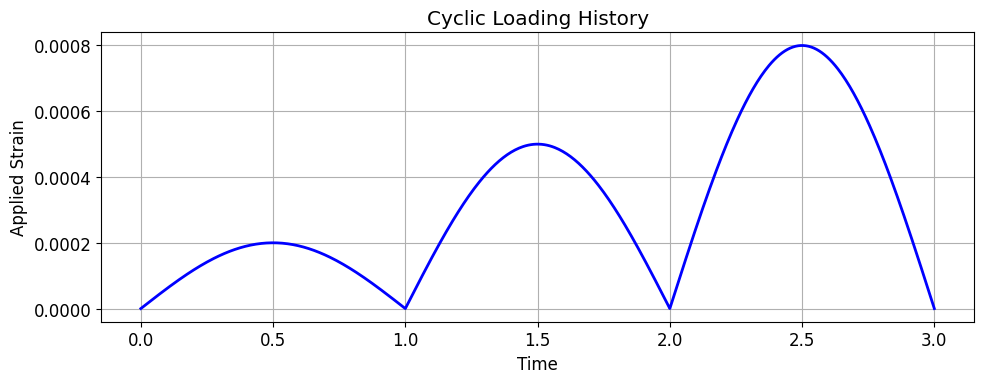

In [4]:
# Create a cyclic loading scenario with increasing amplitude
n_cycles = 3
n_steps_per_cycle = 200
total_steps = n_cycles * n_steps_per_cycle + 1

# Define cyclic strain history with increasing amplitude
t_t = np.linspace(0, n_cycles, total_steps)
strain_max_values = np.linspace(0.0002, 0.0008, n_cycles)  # Increasing max strain

strain = np.zeros(total_steps)
for i in range(n_cycles):
    start_idx = i * n_steps_per_cycle
    end_idx = (i + 1) * n_steps_per_cycle + 1
    
    # Create one loading-unloading cycle
    cycle_time = np.linspace(0, 1, n_steps_per_cycle + 1)
    cycle_strain = strain_max_values[i] * np.sin(cycle_time * np.pi)
    
    strain[start_idx:end_idx] = cycle_strain

print(f"Loading scenario: {n_cycles} cycles, {total_steps} total steps")
print(f"Maximum strain: {np.max(strain):.6f}")

# Plot the loading history
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t_t, strain, 'b-', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Applied Strain')
ax.set_title('Cyclic Loading History')
ax.grid(True)
plt.tight_layout()
plt.show()

## 4. Run the Simulation

Now let's execute the material simulation:

In [5]:
import time
print("Running simulation...")
start_time = time.time()

# Run the simulation
response_data = ed_material.get_F_response(strain, t_t)

end_time = time.time()
print(f"✓ Simulation completed in {end_time - start_time:.2f} seconds")
print(f"✓ Generated {len(response_data.t_t)} data points")

# Quick preview of results
print(f"\nSimulation Summary:")
print(f"  Final strain: {response_data.eps_t[-1, 0]:.6f}")
print(f"  Final stress: {response_data.sig_t[-1, 0, 0]:.2f} MPa")
print(f"  Max stress: {np.max(response_data.sig_t):.2f} MPa")

# Check available internal variables
print(f"  Internal variables: {list(response_data.Eps_t.keys())}")

Running simulation...
✓ Simulation completed in 0.24 seconds
✓ Generated 601 data points

Simulation Summary:
  Final strain: 0.000000
  Final stress: 0.00 MPa
  Max stress: 23.39 MPa
  Internal variables: ['omega_a', 'z_a']
✓ Simulation completed in 0.24 seconds
✓ Generated 601 data points

Simulation Summary:
  Final strain: 0.000000
  Final stress: 0.00 MPa
  Max stress: 23.39 MPa
  Internal variables: ['omega_a', 'z_a']


<lambdifygenerated-1>:11: RuntimeWarning: divide by zero encountered in reciprocal
  x7 = x1**(-1.0)
<lambdifygenerated-1>:15: RuntimeWarning: invalid value encountered in multiply
  x11 = 2*S*x10*x6*x7*x9
<lambdifygenerated-1>:17: RuntimeWarning: invalid value encountered in multiply
  return (array([[x2], [x3]]), x4, array([[-_Dummy_64*x5 + 2*_Dummy_65*S*x10*x6*x7*x9], [_Dummy_63*x5 - _Dummy_65], [x4]]), array([[-_Dummy_65*c*x11/x8 - x5, O, x11], [O, I*x5, x12], [O, x12, O]]))


## 5. Store Results in AiiDA (Optional)

If AiiDA is available, we'll store the simulation results for persistent storage and provenance tracking:

In [6]:
stored_node = None

from bmcs_matmod.gsm_lagrange.aiida_plugin.response_data_node import create_response_data_node

# Prepare simulation metadata
simulation_metadata = {
    "material_model": "GSM1D_ED (Elastic-Damage)",
    "parameters": {
        "E": ed_material.E,
        "S": ed_material.S, 
        "c": ed_material.c,
        "eps_0": ed_material.eps_0
    },
    "loading": {
        "type": "cyclic",
        "n_cycles": n_cycles,
        "max_strain": float(np.max(strain)),
        "total_steps": total_steps
    },
    "computed_metrics": {
        "max_stress": float(np.max(response_data.sig_t)),
        "final_strain": float(response_data.eps_t[-1, 0]),
        "final_stress": float(response_data.sig_t[-1, 0, 0])
    }
}

print("Storing results in AiiDA...")
stored_node = create_response_data_node(
    response_data=response_data,
    simulation_metadata=simulation_metadata,
    store=True,
    auto_load_profile=True
)

print(f"✓ Results stored in AiiDA")
print(f"  Node UUID: {stored_node.uuid}")
print(f"  Node PK: {stored_node.pk if hasattr(stored_node, 'pk') else 'N/A'}")
print(f"  Arrays stored: {stored_node.get_arraynames()}")


Storing results in AiiDA...
✓ Results stored in AiiDA
  Node UUID: a5f84a27-d240-4dbc-9a63-116b8102f750
  Node PK: 791
  Arrays stored: ['time', 'eps', 'sig', 'iterations', 'lambda', 'Eps_t_flat', 'Sig_t_flat', 'Eps_omega_a', 'Eps_z_a', 'Sig_Y_a', 'Sig_Z_a']
✓ Results stored in AiiDA
  Node UUID: a5f84a27-d240-4dbc-9a63-116b8102f750
  Node PK: 791
  Arrays stored: ['time', 'eps', 'sig', 'iterations', 'lambda', 'Eps_t_flat', 'Sig_t_flat', 'Eps_omega_a', 'Eps_z_a', 'Sig_Y_a', 'Sig_Z_a']


## 6. Visualize Results

Let's create comprehensive plots of the simulation results:

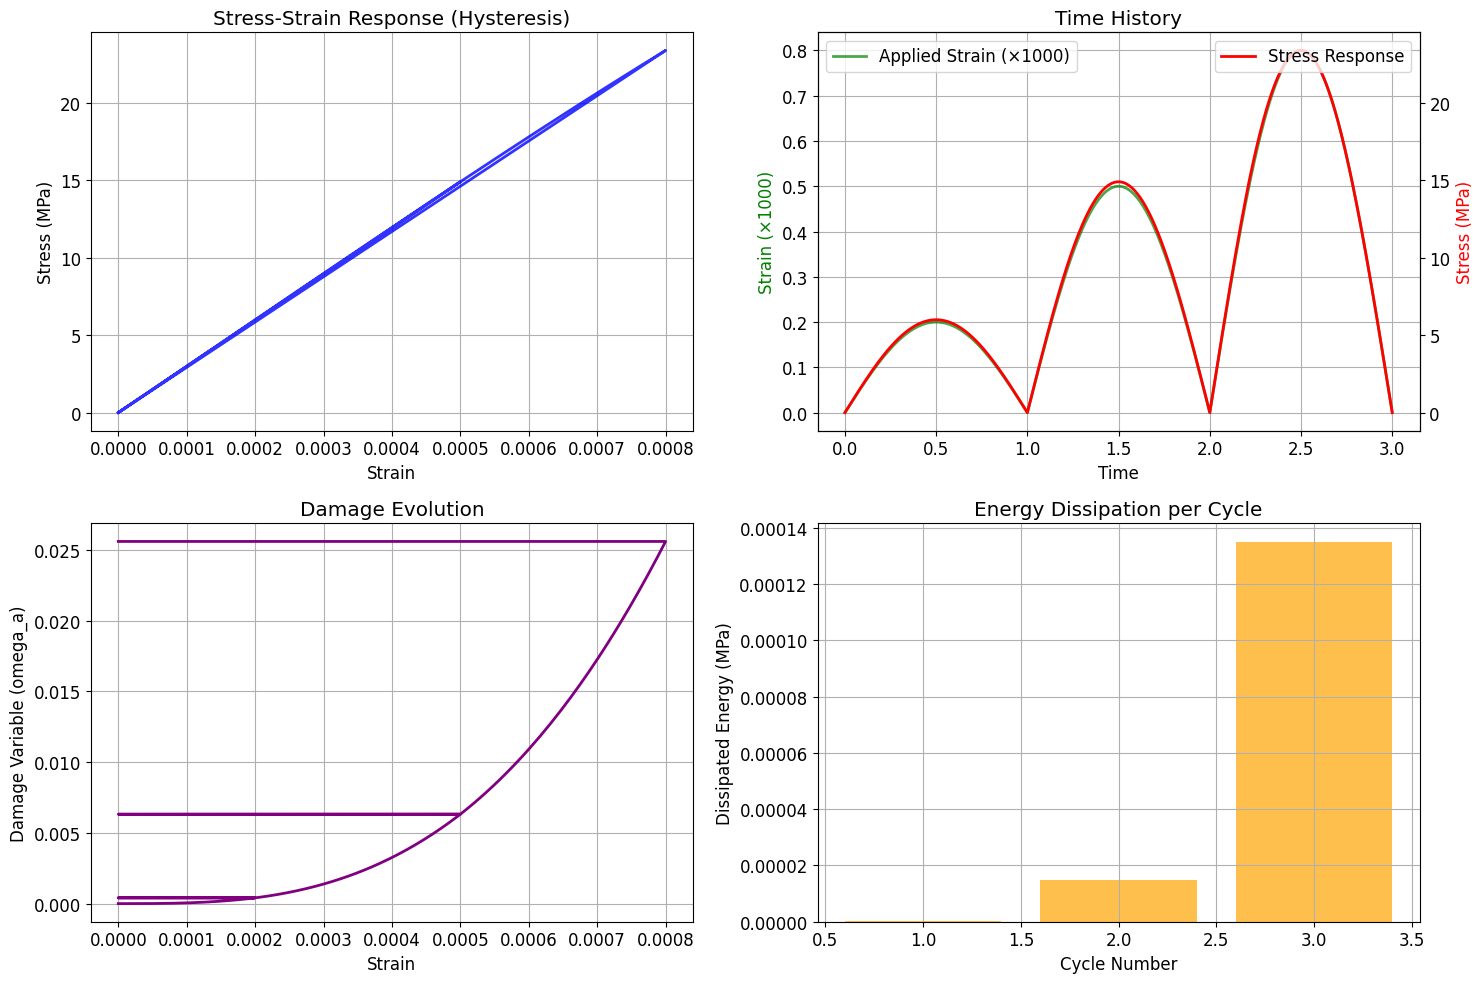


Simulation Results Summary:
  Peak stress: 23.39 MPa
  Residual stress: 0.00 MPa
  Final damage: 0.0256
  Total energy dissipated: 0.0002 MPa
  Average energy per cycle: 0.0001 MPa


In [7]:
# Extract data for plotting
t_t = response_data.t_t
eps = response_data.eps_t[:, 0]
sig = response_data.sig_t[:, 0, 0]

# Get damage variable (internal variable)
damage_key = list(response_data.Eps_t.keys())[0] if response_data.Eps_t else None
if damage_key:
    damage = response_data.Eps_t[damage_key][:, 0, 0]
else:
    damage = np.zeros_like(eps)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Stress-strain hysteresis
ax1.plot(eps, sig, 'b-', linewidth=2, alpha=0.8)
ax1.set_xlabel('Strain')
ax1.set_ylabel('Stress (MPa)')
ax1.set_title('Stress-Strain Response (Hysteresis)')
ax1.grid(True)

# 2. Time history of stress and strain
ax2.plot(t_t, strain*1000, 'g-', linewidth=2, label='Applied Strain (×1000)', alpha=0.7)
ax2_twin = ax2.twinx()
ax2_twin.plot(t_t, sig, 'r-', linewidth=2, label='Stress Response')
ax2.set_xlabel('Time')
ax2.set_ylabel('Strain (×1000)', color='g')
ax2_twin.set_ylabel('Stress (MPa)', color='r')
ax2.set_title('Time History')
ax2.grid(True)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# 3. Damage evolution
if damage_key:
    ax3.plot(eps, damage, 'purple', linewidth=2)
    ax3.set_xlabel('Strain')
    ax3.set_ylabel(f'Damage Variable ({damage_key})')
    ax3.set_title('Damage Evolution')
    ax3.grid(True)
else:
    ax3.text(0.5, 0.5, 'No damage variable available', 
             transform=ax3.transAxes, ha='center', va='center')
    ax3.set_title('Damage Evolution (N/A)')

# 4. Energy dissipation (area of hysteresis loops)
# Calculate approximate energy dissipation per cycle
energy_per_cycle = []
if n_cycles > 1:
    for i in range(n_cycles):
        start_idx = i * n_steps_per_cycle
        end_idx = (i + 1) * n_steps_per_cycle
        cycle_eps = eps[start_idx:end_idx]
        cycle_sig = sig[start_idx:end_idx]
        # Approximate energy as integral using trapezoidal rule
        energy = np.trapezoid(cycle_sig, cycle_eps)
        energy_per_cycle.append(abs(energy))
    
    ax4.bar(range(1, n_cycles+1), energy_per_cycle, alpha=0.7, color='orange')
    ax4.set_xlabel('Cycle Number')
    ax4.set_ylabel('Dissipated Energy (MPa)')
    ax4.set_title('Energy Dissipation per Cycle')
    ax4.grid(True)
else:
    ax4.text(0.5, 0.5, 'Single cycle - no comparison', 
             transform=ax4.transAxes, ha='center', va='center')
    ax4.set_title('Energy Dissipation (N/A)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSimulation Results Summary:")
print(f"  Peak stress: {np.max(sig):.2f} MPa")
print(f"  Residual stress: {sig[-1]:.2f} MPa")
if damage_key:
    print(f"  Final damage: {damage[-1]:.4f}")
if energy_per_cycle:
    print(f"  Total energy dissipated: {sum(energy_per_cycle):.4f} MPa")
    print(f"  Average energy per cycle: {np.mean(energy_per_cycle):.4f} MPa")

## 7. Query and Retrieve Stored Results (AiiDA)

If we successfully stored results in AiiDA, let's demonstrate how to query and retrieve them:

In [8]:
from aiida.orm import QueryBuilder
from bmcs_matmod.gsm_lagrange.aiida_plugin.response_data_node import ResponseDataNode
from datetime import datetime, time

# Create QueryBuilder instance and query for ResponseData nodes created today
qb = QueryBuilder()

# Get today's date at midnight for filtering
today_start = datetime.combine(datetime.today().date(), time.min)

qb.append(ResponseDataNode, 
         filters={
             'ctime': {'>=': today_start}
         },
         project=['uuid', 'pk', 'ctime', 'extras.simulation_metadata'])

# Execute query and assign results
query_results = qb.all()

In [9]:
query_results

[['413e55c6-c451-4463-b2f9-6372d543a628',
  782,
  datetime.datetime(2025, 6, 29, 14, 38, 34, 299396, tzinfo=datetime.timezone.utc),
  None],
 ['46234cc0-a92e-4a9d-9c4a-6ef158a641e4',
  783,
  datetime.datetime(2025, 6, 29, 16, 44, 4, 342764, tzinfo=datetime.timezone.utc),
  None],
 ['3e6e4849-3e81-4bab-bccd-7e39b791ef01',
  784,
  datetime.datetime(2025, 6, 29, 16, 50, 14, 643190, tzinfo=datetime.timezone.utc),
  None],
 ['d331d27d-a04e-443f-b011-d89b25d1b576',
  785,
  datetime.datetime(2025, 6, 29, 16, 52, 23, 571398, tzinfo=datetime.timezone.utc),
  None],
 ['b985dbf5-ffc4-4b0a-aba8-e4e7b396a14b',
  786,
  datetime.datetime(2025, 6, 29, 16, 54, 28, 537135, tzinfo=datetime.timezone.utc),
  None],
 ['90532185-6f4a-4e8f-b4b0-864c1b22641f',
  787,
  datetime.datetime(2025, 6, 29, 17, 10, 59, 603108, tzinfo=datetime.timezone.utc),
  None],
 ['f3b741e9-8bd4-45f1-a293-d4073e3b4bb8',
  788,
  datetime.datetime(2025, 6, 29, 17, 57, 20, 170360, tzinfo=datetime.timezone.utc),
  None],
 ['747d

## 8. Multi-Dataset Dashboard Visualization

Now let's demonstrate how to visualize multiple simulation results in a single dashboard using the split dashboard functionality:

Found 10 ResponseDataNode(s) from today


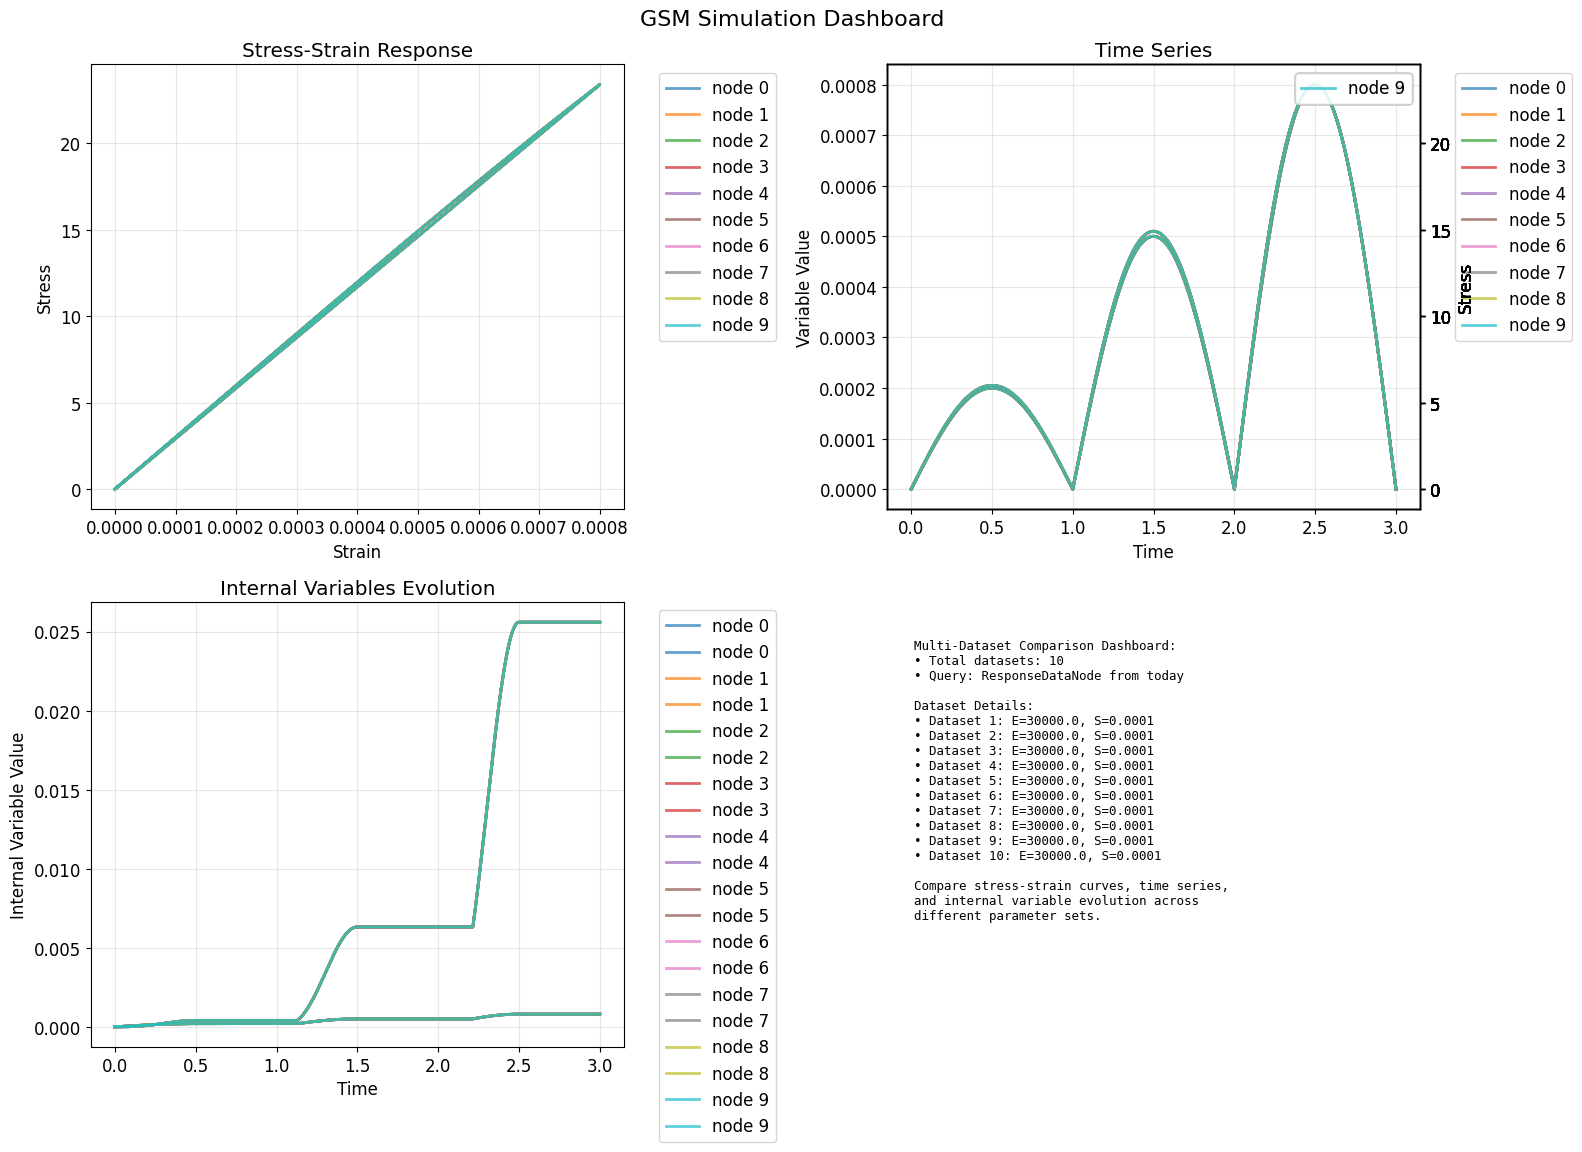


✓ Multi-dataset dashboard created with 10 simulation results


In [12]:
if query_results:
    print(f"Found {len(query_results)} ResponseDataNode(s) from today")
    
    # Load the nodes
    from aiida.orm import load_node
    nodes = [load_node(result[1]) for result in query_results]  # result[1] is the pk
    
    # Create a single dashboard layout (once)
    first_response = nodes[0].to_response_data()
    fig, axes = first_response.create_dashboard(figsize=(16, 12))
    
    # Use different colors for each dataset
    import matplotlib.cm as cm
    colors = cm.tab10(range(len(nodes)))
    
    # Fill the dashboard with all datasets
    for i, node in enumerate(nodes):
        response_data_from_node = node.to_response_data()
        
        # Get metadata for labeling
        metadata = node.get_simulation_metadata()
        material_model = metadata.get('material_model', 'Unknown')
        params = metadata.get('parameters', {})
        E_value = params.get('E', 'Unknown')
        
        label = f"node {i}"
        
        # Fill the dashboard with this dataset
        response_data_from_node.fill_dashboard(
            axes, 
            label=label, 
            color=colors[i], 
            alpha=0.7,
            linewidth=2
        )
    
    # Update the summary panel for multiple datasets
    axes[1, 1].clear()
    axes[1, 1].axis('off')
    
    summary_text = f"""
Multi-Dataset Comparison Dashboard:
• Total datasets: {len(nodes)}
• Query: ResponseDataNode from today

Dataset Details:
"""
    
    for i, node in enumerate(nodes):
        metadata = node.get_simulation_metadata()
        params = metadata.get('parameters', {})
        summary_text += f"• Dataset {i+1}: E={params.get('E', 'N/A')}, S={params.get('S', 'N/A')}\n"
    
    summary_text += """
Compare stress-strain curves, time series,
and internal variable evolution across
different parameter sets.
"""
    
    axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                    fontsize=9, verticalalignment='top', fontfamily='monospace')
    
    # Improve legend positioning
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Multi-dataset dashboard created with {len(nodes)} simulation results")
    
else:
    print("No query results found. Create multiple simulations with different parameters to see the multi-dataset dashboard.")
    
    # Demonstrate with the current data anyway
    print("\n📊 Demonstrating split dashboard methods with current data:")
    
    # Create dashboard layout
    fig, axes = response_data.create_dashboard(figsize=(14, 10))
    
    # Fill with current response data
    response_data.fill_dashboard(axes, label="Current Simulation")
    
    plt.show()
    
    print("✓ Single-dataset dashboard created using split methods")

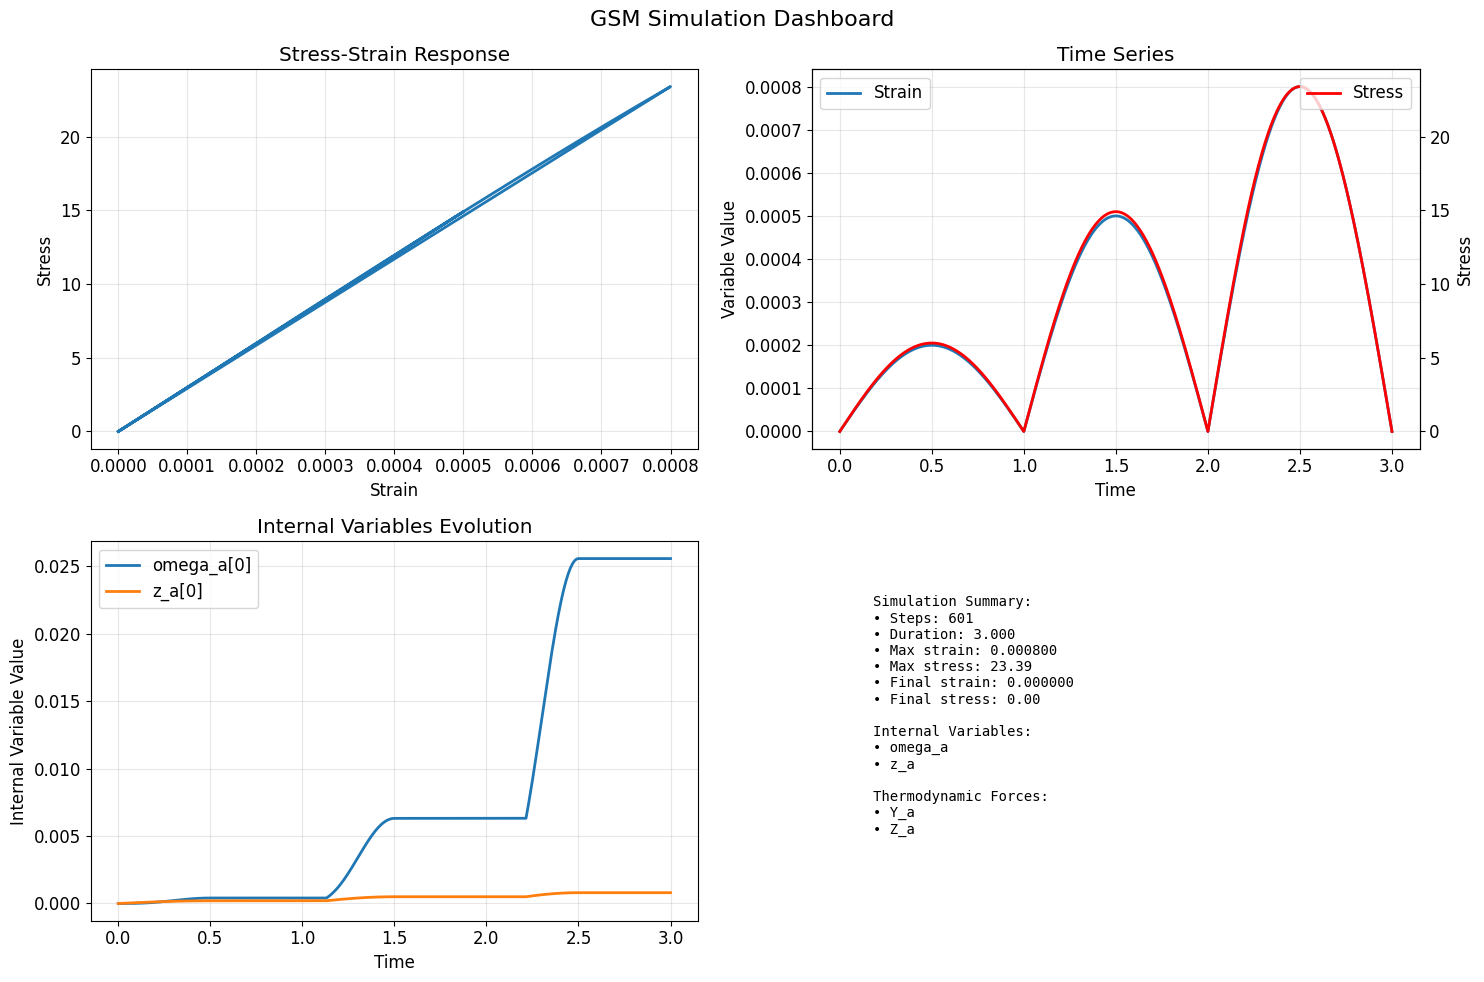

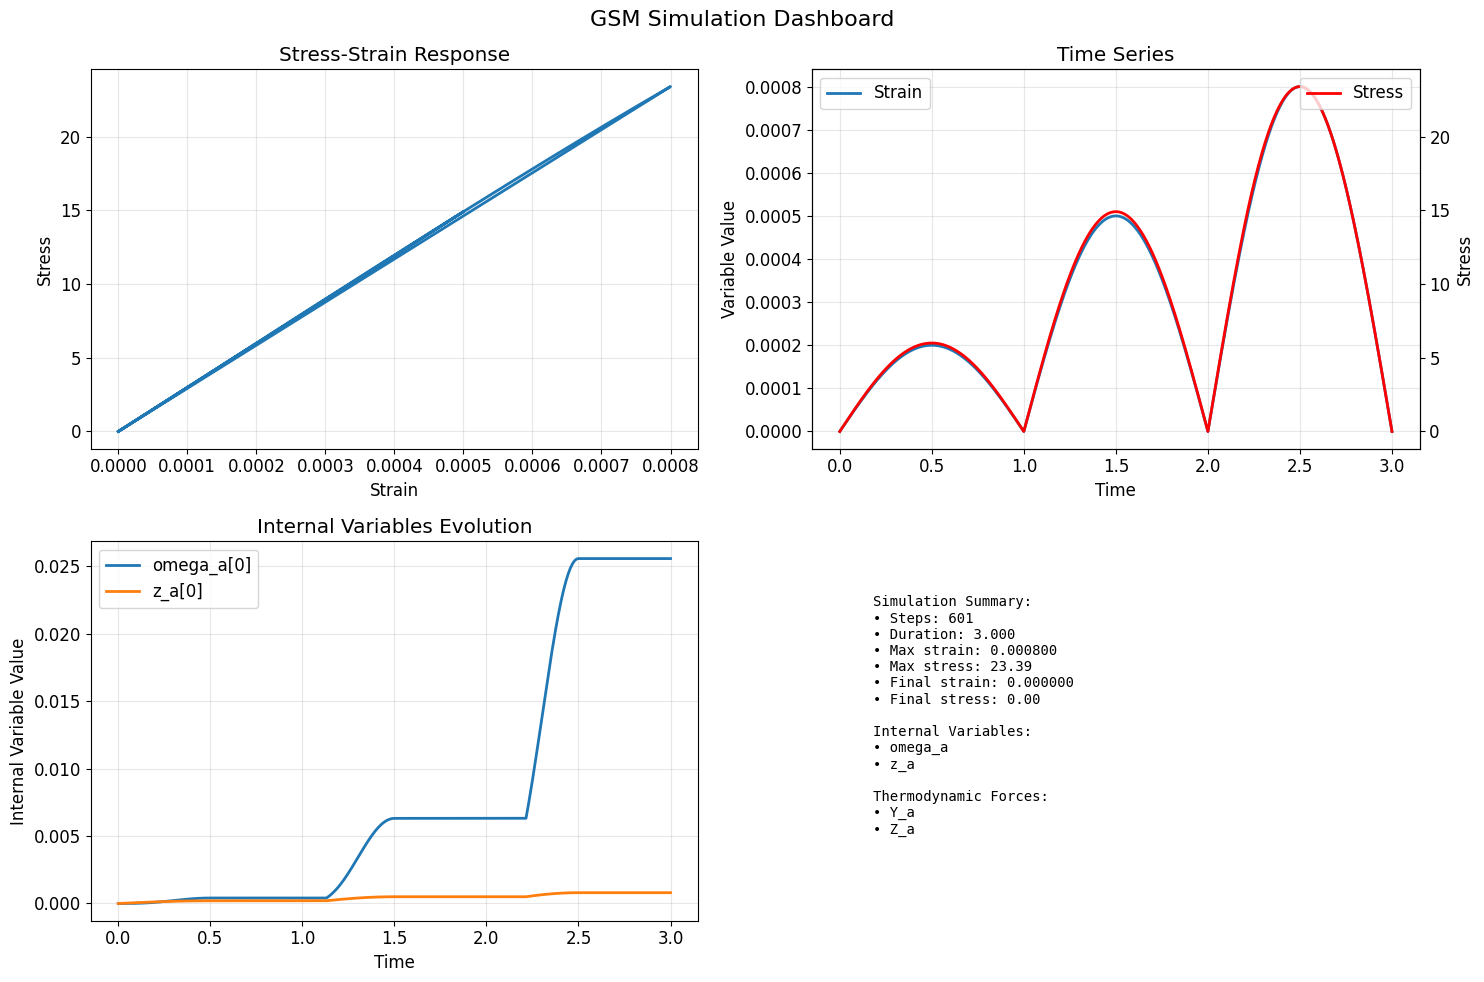

In [8]:
response_data.create_dashboard()

In [8]:
if stored_node is not None:
    print("=== AiiDA Node Information ===")
    
    # Basic node information
    print(f"Node UUID: {stored_node.uuid}")
    print(f"Node Type: {type(stored_node).__name__}")
    print(f"Is Stored: {stored_node.is_stored}")
    if hasattr(stored_node, 'ctime'):
        print(f"Creation Time: {stored_node.ctime}")
    
    # Stored arrays
    print(f"\nStored Arrays: {stored_node.get_arraynames()}")
    
    # Simulation metadata
    sim_info = stored_node.get_simulation_info()
    print(f"\nSimulation Info:")
    for key, value in sim_info.items():
        print(f"  {key}: {value}")
    
    # Custom metadata
    metadata = stored_node.get_simulation_metadata()
    print(f"\nCustom Metadata:")
    print(f"  Material Model: {metadata.get('material_model', 'N/A')}")
    print(f"  Loading Type: {metadata.get('loading', {}).get('type', 'N/A')}")
    
    # Demonstrate data retrieval
    print(f"\n=== Data Retrieval Test ===")
    retrieved_response = stored_node.to_response_data()
    print(f"✓ Successfully retrieved ResponseData from storage")
    print(f"  Time points: {len(retrieved_response.t_t)}")
    print(f"  Strain range: {np.min(retrieved_response.eps_t):.6f} to {np.max(retrieved_response.eps_t):.6f}")
    print(f"  Stress range: {np.min(retrieved_response.sig_t):.2f} to {np.max(retrieved_response.sig_t):.2f} MPa")
    
    # Verify data integrity
    data_match = np.allclose(response_data.eps_t, retrieved_response.eps_t)
    print(f"  Data integrity check: {'✓ PASSED' if data_match else '❌ FAILED'}")
    
else:
    print("=== No AiiDA Storage ===")
    print("Results are available in memory only.")
    print("To enable persistent storage:")
    print("  1. Install AiiDA: pip install aiida-core")
    print("  2. Setup a profile: verdi setup")
    print("  3. Re-run this notebook")

=== AiiDA Node Information ===
Node UUID: 413e55c6-c451-4463-b2f9-6372d543a628
Node Type: ResponseDataNode
Is Stored: True
Creation Time: 2025-06-29 14:38:34.299396+00:00

Stored Arrays: ['time', 'eps', 'sig', 'iterations', 'lambda', 'Eps_t_flat', 'Sig_t_flat', 'Eps_omega_a', 'Eps_z_a', 'Sig_Y_a', 'Sig_Z_a']

Simulation Info:
  n_steps: 601
  time_range: [0.0, 3.0]
  eps_range: [0.0, 0.0008]
  sig_range: [0.0, 23.38590872991]

Custom Metadata:
  Material Model: GSM1D_ED (Elastic-Damage)
  Loading Type: cyclic

=== Data Retrieval Test ===
✓ Successfully retrieved ResponseData from storage
  Time points: 601
  Strain range: 0.000000 to 0.000800
  Stress range: 0.00 to 23.39 MPa
  Data integrity check: ✓ PASSED


## 8. Export Results (Alternative Storage)

For cases where AiiDA is not available, we can export results to standard formats:

In [9]:
import json
from datetime import datetime

# Create exportable results dictionary
export_data = {
    "metadata": {
        "timestamp": datetime.now().isoformat(),
        "material_model": "GSM1D_ED",
        "framework": "bmcs_matmod.gsm_lagrange",
        "parameters": {
            "E": float(ed_material.E),
            "S": float(ed_material.S),
            "c": float(ed_material.c),
            "eps_0": float(ed_material.eps_0)
        },
        "loading": {
            "type": "cyclic",
            "n_cycles": n_cycles,
            "total_steps": total_steps,
            "max_strain": float(np.max(strain))
        }
    },
    "results": {
        "time": t_t.tolist(),
        "applied_strain": strain.tolist(),
        "strain": eps.tolist(),
        "stress": sig.tolist(),
        "n_steps": len(t_t)
    }
}

# Add internal variables if available
if response_data.Eps_t:
    export_data["results"]["internal_variables"] = {}
    for var_name, var_data in response_data.Eps_t.items():
        if isinstance(var_data, np.ndarray):
            # Flatten for JSON serialization
            flattened = var_data.flatten() if var_data.ndim > 1 else var_data
            export_data["results"]["internal_variables"][var_name] = flattened.tolist()

# Add summary statistics
export_data["summary"] = {
    "max_stress": float(np.max(sig)),
    "final_stress": float(sig[-1]),
    "final_strain": float(eps[-1]),
    "peak_strain": float(np.max(eps))
}

# Export to JSON
json_filename = f"gsm_simulation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(json_filename, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Results exported to: {json_filename}")
print(f"  File size: {len(json.dumps(export_data)) / 1024:.1f} KB")
print(f"  Contains: {len(export_data['results']['time'])} data points")

# Also save plots
plot_filename = f"gsm_simulation_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"✓ Plots saved to: {plot_filename}")

✓ Results exported to: gsm_simulation_results_20250629_163839.json
  File size: 65.3 KB
  Contains: 601 data points
✓ Plots saved to: gsm_simulation_plots_20250629_163839.png


## Summary

This notebook demonstrated a complete workflow for GSM Lagrange material simulations with optional AiiDA integration:

### ✅ What we accomplished:
1. **Material Model Setup**: Configured an elastic-damage model with realistic parameters
2. **Simulation Execution**: Ran a cyclic loading simulation with damage accumulation
3. **AiiDA Storage**: Conditionally stored results in AiiDA with full metadata and provenance
4. **Comprehensive Visualization**: Created multi-panel plots showing stress-strain response, damage evolution, and energy dissipation
5. **Data Retrieval**: Demonstrated how to query and retrieve stored results from AiiDA
6. **Alternative Export**: Provided JSON export for non-AiiDA environments

### 🔧 Architecture Benefits:
- **Optional AiiDA**: Code works with or without AiiDA installation
- **Automatic Profile Management**: Handles AiiDA profile loading gracefully
- **Rich Metadata**: Stores complete simulation context for reproducibility
- **Data Integrity**: Verifies round-trip data consistency
- **Multiple Export Formats**: Supports both AiiDA nodes and standard formats

### 🚀 Next Steps:
- Implement more complex loading scenarios
- Add parameter optimization workflows
- Create AiiDA WorkChains for automated studies
- Integrate with experimental data comparison tools

This workflow provides a robust foundation for computational materials science with modern data management practices.